In [1]:
import openmc
import openmc.deplete # will be needed for depletion analysis eventually
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Create the assembly-cell model

### Materials

In [2]:
# materials

NpO2 = openmc.Material();
NpO2.add_nuclide('Np237',1);
NpO2.add_element('O',2);
NpO2.set_density('g/cc',11.143);

Al = openmc.Material();
Al.add_element('Al',1);
Al.set_density('g/cc',2.7);


target = openmc.Material.mix_materials([NpO2,Al],[0.2,0.7],'vo',
                                      name='target'); 
target.depletable = True
# note: 10% is void so expect to get a UserWarning on this.


# materials for fuel pin
uo2 = openmc.Material(name='UO2')
uo2.add_element('U',1.0, enrichment=5.0)
uo2.add_element('O',2.0)
uo2.set_density('g/cc',10.45)
uo2.depletable = True

# cladding

# based on PNNL-15870 Rev 1. 
zirc4 = openmc.Material(name='Zirc-4')
zirc4.add_element('O',0.006790); # by default add_element in atom fraction.
zirc4.add_element('Cr',0.001741);
zirc4.add_element('Fe',0.003242);
zirc4.add_element('Zr',0.977549);
zirc4.add_element('Sn',0.010677);
zirc4.set_density('g/cc',6.56);

# gap will be modeled as a void

water = openmc.Material(name='Water')
water.set_density('g/cc',0.76);
water.add_element('H',2);
water.add_element('O',1);
water.add_s_alpha_beta('c_H_in_H2O');




/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/material.py:1177: UserWarning: Warning: sum of fractions do not add to 1, void fraction set to 0.10000000000000009
  warnings.warn(msg)


### Geometry

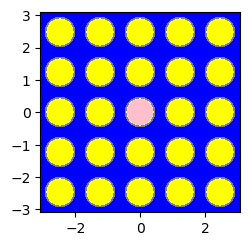

In [3]:
# create the surfaces

r_fo = 0.4096 # cm, fuel outer radius
r_ci = 0.4179 # cm, clad inner radius
r_co = 0.4751 # cm, clad outer radius

fuel_outer_radius = openmc.ZCylinder(r=r_fo);
clad_inner_radius = openmc.ZCylinder(r=r_ci);
clad_outer_radius = openmc.ZCylinder(r=r_co);

# define the regions

fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius
coolant_region = +clad_outer_radius

# define cells for a universe containing a fuel (UO2) pin

fuel = openmc.Cell(name='fuel');
fuel.fill = uo2;
fuel.region = fuel_region;

gap_f = openmc.Cell(name='gap_f');
gap_f.region = gap_region;
# no fill.  Makes it void by default

clad_f = openmc.Cell(name='clad_f');
clad_f.fill = zirc4;
clad_f.region = clad_region

coolant_f = openmc.Cell(name='coolant_f');
coolant_f.fill = water;
coolant_f.region = coolant_region;

# define the fuel pin universe

fp = openmc.Universe()
fp.add_cells([fuel,gap_f,clad_f,coolant_f]);

# define cells for a target pin universe

fuel_t = openmc.Cell(name='fuel_t');
fuel_t.region = fuel_region;
fuel_t.fill = target

gap_t = openmc.Cell(name='gap_t');
gap_t.region = gap_region;

clad_t = openmc.Cell(name='clad_t');
clad_t.fill = zirc4
clad_t.region = clad_region;

coolant_t = openmc.Cell(name='coolant_t');
coolant_t.fill = water
coolant_t.region = coolant_region 

tp = openmc.Universe()
tp.add_cells([fuel_t,gap_t,clad_t,coolant_t]);

# We also want to define an "all coolant" universe to use with the lattice we will be making.

all_coolant_cell = openmc.Cell(name='all_coolant_cell')
all_coolant_cell.fill = water
# with no region, water will just be everywhere (I think!!)

cu = openmc.Universe()
cu.add_cells([all_coolant_cell]);

# create the assembly/core geometry

P_D = 1.3     # pitch/diameter ratio
N_assy = 5; # number of pins per dimension in the assembly, i.e. N_assy x N_assy 

pitch = r_co*2.*P_D; # cm, pin pitch
a_pitch = N_assy*pitch # cm, assembly pitch

h_assy = 100; # cm, height of the assembly model

assy_box = openmc.model.RectangularParallelepiped(-a_pitch/2.,a_pitch/2.,
                                                  -a_pitch/2.,a_pitch/2.,
                                                  -h_assy/2.,h_assy/2.,
                                                  boundary_type='reflective');
# other boundary types = 'periodic' and 'vacuum'

assy_lat = openmc.RectLattice()
assy_lat.center = (0.,0.)
assy_lat.dimension = [N_assy,N_assy]
assy_lat.lower_left = [-N_assy/2.*pitch,-N_assy/2.*pitch]
assy_lat.pitch = [pitch,pitch]
assy_lat.universes=[
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, tp, fp, fp],
    [fp, fp, fp, fp, fp],
    [fp, fp, fp, fp, fp]
]
assy_lat.outer = cu; # coolant universe is outside of the assy lattice.

assy_u = openmc.Universe()
assy_cell = openmc.Cell()
assy_cell.fill = assy_lat;
assy_cell.region = -assy_box
assy_u.add_cell(assy_cell);

# define a colors dictionary so we can tell OpenMC how to color our plots
colors = {}
colors[water]='blue';
colors[uo2]='yellow';
colors[zirc4]='gray';
colors[target]='pink';

# plot the assembly universe and make sure it looks right.
assy_u.plot(width=(a_pitch,a_pitch),color_by='material',colors=colors)

In [4]:
# create the geometry and export to XML

geometry = openmc.Geometry()
geometry.root_universe = assy_u

geometry.export_to_xml()

# Add volume calculation to materials and write materials to xml

# volume calc for target:
num_tgt_pins = 1;
num_fuel_pins = 24;
target.volume = np.pi*(r_fo**2)*h_assy*num_tgt_pins
uo2.volume = np.pi*(r_fo**2)*h_assy*num_fuel_pins

materials = openmc.Materials([target, uo2, zirc4, water]);
materials.export_to_xml();

### Tallies

In [5]:
# filters for energy, cells, and reactions
cell_filter = openmc.CellFilter(fuel_t); # measure in the target material cell

cell_filter_assy = openmc.CellFilter(assy_cell);

# energy bins
N = 1001;
energy_bins = np.logspace(-3,7,num=N);
energy_filter = openmc.EnergyFilter(values=energy_bins);

# establish a flux tally for the target
flux_target = openmc.Tally(name='flux in target');
flux_target.scores = ['flux'];
flux_target.filters = [cell_filter,energy_filter];

# avg flux for the whole core
flux_avg = openmc.Tally(name='avg flux')
flux_avg.scores = ['flux'];
flux_avg.filters = [cell_filter_assy, energy_filter];



# create a tally to estimate rate of conversion of Np-237 to Np-238
np237_capture_t = openmc.Tally(name='Np237_total_capture');
np237_capture_t.scores = ['(n,gamma)'];
np237_capture_t.nuclides=['Np237'];
efilter_values = [0.0, 1.0, 3.0e4, 14.0e6]; #OpenMC energy units are in eV
efilter_capture = openmc.EnergyFilter(values=efilter_values);
np237_capture_t.filters = [cell_filter,efilter_capture]

tallies = openmc.Tallies([flux_target,flux_avg,np237_capture_t]);
tallies.export_to_xml()

In [6]:
# create settings for criticality

settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50;

box = openmc.stats.Box(lower_left=(-a_pitch/2.,-a_pitch/2.,-h_assy/2.),
                      upper_right=(a_pitch/2.,a_pitch/2.,h_assy/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);
settings.source = src;

settings.export_to_xml();

## Conduct Depletion Calculation

In [7]:
model = openmc.model.Model(geometry,materials,settings,tallies)
operator = openmc.deplete.CoupledOperator(model,"chain_casl_pwr.xml");

# Typical PWR power_density = 30.5 W/gHM
power_density = 30.5; # W/gHM
days = 24*3600;
time_steps = [0.25*days, 0.25*days, 0.25*days, 0.25*days, 0.5*days, 0.5*days,
              1.0*days, 1.0*days, 1.0*days, 1.0*days, 4.0*days, 4.0*days, 
              4.0*days, 4.0*days,4.0*days, 4*days, 4*days, 4*days,4*days];

cecm = openmc.deplete.CECMIntegrator(operator,time_steps,power_density=power_density);


repeat_depletion = True;

if(repeat_depletion):
    cecm.integrate()



                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5


 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd106.h5
 Reading Pd107 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd107.h5
 Reading Pd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd108.h5
 Reading Ag107 from /home/sblair/OMC_DATA/

 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5


          1200K
          2500K


 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce143.h5
 Reading Ce144 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce144.h5
 Reading Pr141 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr141.h5
 Reading Pr142 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr142.h5
 Reading Pr143 from /home/sblair/OMC_DATA/endfb71_hdf5/Pr143.h5
 Reading Nd142 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd142.h5
 Reading Nd143 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd143.h5
 Reading Nd144 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd144.h5
 Reading Nd145 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd145.h5
 Reading Nd146 from /home/sblair/OMC_DATA/endfb71_hdf5/Nd146.h5
 Reading Nd147 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy163.h5
 Reading Dy164 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy164.h5
 Reading Ho165 from /home/sblair/OMC_DATA/endfb71_hdf5/Ho165.h5
 Reading Er162 from /home/sblair/OMC_DAT

      109/1    1.33265    1.34612 +/- 0.00177
      110/1    1.33611    1.34595 +/- 0.00174
      111/1    1.32536    1.34561 +/- 0.00175
      112/1    1.35381    1.34575 +/- 0.00172
      113/1    1.34664    1.34576 +/- 0.00170
      114/1    1.36112    1.34600 +/- 0.00169
      115/1    1.35127    1.34608 +/- 0.00166
      116/1    1.35981    1.34629 +/- 0.00165
      117/1    1.33369    1.34610 +/- 0.00164
      118/1    1.34776    1.34613 +/- 0.00161
      119/1    1.33611    1.34598 +/- 0.00160
      120/1    1.35247    1.34607 +/- 0.00158
      121/1    1.34204    1.34602 +/- 0.00155
      122/1    1.36776    1.34632 +/- 0.00156
      123/1    1.35256    1.34640 +/- 0.00154
      124/1    1.35090    1.34646 +/- 0.00152
      125/1    1.35868    1.34663 +/- 0.00151
      126/1    1.34901    1.34666 +/- 0.00149
      127/1    1.34754    1.34667 +/- 0.00147
      128/1    1.35644    1.34680 +/- 0.00146
      129/1    1.35623    1.34691 +/- 0.00145
      130/1    1.33417    1.34676 

       78/1    1.35447    1.34778 +/- 0.00236
       79/1    1.34961    1.34785 +/- 0.00228
       80/1    1.35193    1.34798 +/- 0.00220
       81/1    1.33005    1.34740 +/- 0.00221
       82/1    1.34071    1.34720 +/- 0.00215
       83/1    1.34772    1.34721 +/- 0.00208
       84/1    1.34302    1.34709 +/- 0.00202
       85/1    1.35030    1.34718 +/- 0.00197
       86/1    1.33604    1.34687 +/- 0.00194
       87/1    1.34946    1.34694 +/- 0.00189
       88/1    1.34490    1.34689 +/- 0.00184
       89/1    1.34036    1.34672 +/- 0.00180
       90/1    1.34274    1.34662 +/- 0.00175
       91/1    1.33033    1.34622 +/- 0.00176
       92/1    1.32979    1.34583 +/- 0.00176
       93/1    1.33815    1.34565 +/- 0.00173
       94/1    1.33971    1.34552 +/- 0.00169
       95/1    1.35467    1.34572 +/- 0.00167
       96/1    1.34511    1.34571 +/- 0.00163
       97/1    1.35896    1.34599 +/- 0.00162
       98/1    1.33793    1.34582 +/- 0.00159
       99/1    1.33609    1.34562 

       41/1    1.33920
       42/1    1.33439
       43/1    1.32937
       44/1    1.33678
       45/1    1.33891
       46/1    1.35049
       47/1    1.36615
       48/1    1.36180
       49/1    1.31804
       50/1    1.35477
       51/1    1.34511
       52/1    1.34742    1.34627 +/- 0.00115
       53/1    1.34956    1.34736 +/- 0.00128
       54/1    1.36656    1.35216 +/- 0.00488
       55/1    1.34793    1.35131 +/- 0.00388
       56/1    1.32505    1.34694 +/- 0.00540
       57/1    1.34860    1.34717 +/- 0.00457
       58/1    1.35618    1.34830 +/- 0.00412
       59/1    1.33622    1.34696 +/- 0.00387
       60/1    1.35352    1.34761 +/- 0.00352
       61/1    1.34422    1.34731 +/- 0.00320
       62/1    1.35346    1.34782 +/- 0.00297
       63/1    1.34713    1.34776 +/- 0.00273
       64/1    1.32834    1.34638 +/- 0.00288
       65/1    1.34806    1.34649 +/- 0.00269
       66/1    1.36237    1.34748 +/- 0.00270
       67/1    1.33675    1.34685 +/- 0.00262
       68/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.34279
        2/1    1.33406
        3/1    1.31989
        4/1    1.35913
        5/1    1.33993
        6/1    1.35001
        7/1    1.30815
        8/1    1.33718
        9/1    1.33229
       10/1    1.32006
       11/1    1.33435
       12/1    1.34785
       13/1    1.33978
       14/1    1.34594
       15/1    1.32254
       16/1    1.31824
       17/1    1.34560
       18/1    1.35227
       19/1    1.33361
       20/1    1.35169
       21/1    1.32617
       22/1    1.33170
       23/1    1.32790
       24/1    1.35479
       25/1    1.32046
       26/1    1.33022
       27/1    1.35762
       28/1    1.33253
       29/1    1.33608
       30/1    1.31581
       31/1    1.33821
       32/1    1.35148
       3

      200/1    1.33637    1.33223 +/- 0.00104
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8469e+02 seconds
   Time in transport only          = 2.8343e+02 seconds
   Time in inactive batches        = 4.4900e+01 seconds
   Time in active batches          = 2.3979e+02 seconds
   Time synchronizing fission bank = 4.6338e-01 seconds
     Sampling source sites         = 4.1329e-01 seconds
     SEND/RECV source sites        = 4.8910e-02 seconds
   Time accumulating tallies       = 5.3637e-01 seconds
   Time writing statepoints        = 1.9124e-02 seconds
 Total time for finalization       = 3.3376e-03 seconds
 Total time elapsed                = 2.8495e+02 seconds
 Calculation Rate (inactive)       = 22271.6 particles/second
 Calculation Rate (active)         = 12511

      169/1    1.32922    1.32954 +/- 0.00110
      170/1    1.32932    1.32954 +/- 0.00109
      171/1    1.31307    1.32940 +/- 0.00109
      172/1    1.34319    1.32952 +/- 0.00108
      173/1    1.32134    1.32945 +/- 0.00108
      174/1    1.34974    1.32961 +/- 0.00108
      175/1    1.34034    1.32970 +/- 0.00108
      176/1    1.31711    1.32960 +/- 0.00107
      177/1    1.32778    1.32959 +/- 0.00106
      178/1    1.34029    1.32967 +/- 0.00106
      179/1    1.34491    1.32979 +/- 0.00106
      180/1    1.33492    1.32983 +/- 0.00105
      181/1    1.35471    1.33002 +/- 0.00106
      182/1    1.32973    1.33002 +/- 0.00105
      183/1    1.35144    1.33018 +/- 0.00105
      184/1    1.31407    1.33006 +/- 0.00105
      185/1    1.32570    1.33002 +/- 0.00105
      186/1    1.33025    1.33003 +/- 0.00104
      187/1    1.33013    1.33003 +/- 0.00103
      188/1    1.32893    1.33002 +/- 0.00102
      189/1    1.34884    1.33015 +/- 0.00103
      190/1    1.31145    1.33002 

      138/1    1.33505    1.32430 +/- 0.00111
      139/1    1.31322    1.32418 +/- 0.00111
      140/1    1.30580    1.32397 +/- 0.00111
      141/1    1.31791    1.32391 +/- 0.00110
      142/1    1.32988    1.32397 +/- 0.00109
      143/1    1.33060    1.32404 +/- 0.00108
      144/1    1.33383    1.32415 +/- 0.00108
      145/1    1.32719    1.32418 +/- 0.00107
      146/1    1.31963    1.32413 +/- 0.00106
      147/1    1.32989    1.32419 +/- 0.00105
      148/1    1.31255    1.32407 +/- 0.00104
      149/1    1.31144    1.32394 +/- 0.00104
      150/1    1.32468    1.32395 +/- 0.00103
      151/1    1.31544    1.32387 +/- 0.00102
      152/1    1.32487    1.32388 +/- 0.00101
      153/1    1.33466    1.32398 +/- 0.00101
      154/1    1.32776    1.32402 +/- 0.00100
      155/1    1.32917    1.32407 +/- 0.00099
      156/1    1.34102    1.32423 +/- 0.00099
      157/1    1.31831    1.32417 +/- 0.00099
      158/1    1.34876    1.32440 +/- 0.00100
      159/1    1.33943    1.32454 

      107/1    1.33036    1.31950 +/- 0.00169
      108/1    1.35925    1.32018 +/- 0.00180
      109/1    1.33104    1.32036 +/- 0.00178
      110/1    1.32148    1.32038 +/- 0.00175
      111/1    1.31616    1.32031 +/- 0.00172
      112/1    1.32109    1.32033 +/- 0.00169
      113/1    1.31333    1.32022 +/- 0.00167
      114/1    1.33111    1.32039 +/- 0.00165
      115/1    1.31604    1.32032 +/- 0.00163
      116/1    1.30580    1.32010 +/- 0.00162
      117/1    1.31192    1.31998 +/- 0.00160
      118/1    1.30422    1.31974 +/- 0.00159
      119/1    1.31162    1.31963 +/- 0.00157
      120/1    1.31406    1.31955 +/- 0.00155
      121/1    1.33217    1.31973 +/- 0.00154
      122/1    1.31667    1.31968 +/- 0.00152
      123/1    1.30619    1.31950 +/- 0.00151
      124/1    1.32871    1.31962 +/- 0.00149
      125/1    1.29398    1.31928 +/- 0.00151
      126/1    1.33124    1.31944 +/- 0.00150
      127/1    1.32752    1.31954 +/- 0.00148
      128/1    1.33795    1.31978 

       76/1    1.29981    1.32005 +/- 0.00267
       77/1    1.32283    1.32015 +/- 0.00257
       78/1    1.30213    1.31950 +/- 0.00256
       79/1    1.31886    1.31948 +/- 0.00247
       80/1    1.32287    1.31960 +/- 0.00239
       81/1    1.31466    1.31944 +/- 0.00232
       82/1    1.33013    1.31977 +/- 0.00227
       83/1    1.30226    1.31924 +/- 0.00226
       84/1    1.32418    1.31938 +/- 0.00220
       85/1    1.31290    1.31920 +/- 0.00214
       86/1    1.32048    1.31924 +/- 0.00208
       87/1    1.32701    1.31945 +/- 0.00204
       88/1    1.30051    1.31895 +/- 0.00205
       89/1    1.30952    1.31871 +/- 0.00201
       90/1    1.31085    1.31851 +/- 0.00197
       91/1    1.30327    1.31814 +/- 0.00195
       92/1    1.33324    1.31850 +/- 0.00194
       93/1    1.31758    1.31848 +/- 0.00189
       94/1    1.33940    1.31895 +/- 0.00191
       95/1    1.33179    1.31924 +/- 0.00189
       96/1    1.31605    1.31917 +/- 0.00185
       97/1    1.32316    1.31925 

       37/1    1.32870
       38/1    1.28670
       39/1    1.30105
       40/1    1.32244
       41/1    1.31955
       42/1    1.31650
       43/1    1.31850
       44/1    1.32171
       45/1    1.33045
       46/1    1.32309
       47/1    1.30270
       48/1    1.31540
       49/1    1.31843
       50/1    1.32636
       51/1    1.30762
       52/1    1.33228    1.31995 +/- 0.01233
       53/1    1.31137    1.31709 +/- 0.00767
       54/1    1.32593    1.31930 +/- 0.00586
       55/1    1.32350    1.32014 +/- 0.00461
       56/1    1.31021    1.31848 +/- 0.00412
       57/1    1.30642    1.31676 +/- 0.00388
       58/1    1.32157    1.31736 +/- 0.00341
       59/1    1.33686    1.31953 +/- 0.00371
       60/1    1.30267    1.31784 +/- 0.00372
       61/1    1.31241    1.31735 +/- 0.00340
       62/1    1.30752    1.31653 +/- 0.00321
       63/1    1.30953    1.31599 +/- 0.00300
       64/1    1.30715    1.31536 +/- 0.00285
       65/1    1.30207    1.31447 +/- 0.00280
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.30299
        2/1    1.33354
        3/1    1.31106
        4/1    1.31559
        5/1    1.32166
        6/1    1.31663
        7/1    1.31893
        8/1    1.32341
        9/1    1.33232
       10/1    1.30104
       11/1    1.30110
       12/1    1.29153
       13/1    1.31525
       14/1    1.31730
       15/1    1.32040
       16/1    1.30780
       17/1    1.31350
       18/1    1.30959
       19/1    1.32207
       20/1    1.32152
       21/1    1.31601
       22/1    1.30404
       23/1    1.32701
       24/1    1.30913
       25/1    1.33368
       26/1    1.31710
       27/1    1.31755
       28/1    1.30617
       29/1    1.30660
       30/1    1.30555
       31/1    1.31402
       32/1    1.31438
       3

      200/1    1.29612    1.31399 +/- 0.00095
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8462e+02 seconds
   Time in transport only          = 2.8329e+02 seconds
   Time in inactive batches        = 4.4599e+01 seconds
   Time in active batches          = 2.4002e+02 seconds
   Time synchronizing fission bank = 4.5189e-01 seconds
     Sampling source sites         = 3.9921e-01 seconds
     SEND/RECV source sites        = 5.1489e-02 seconds
   Time accumulating tallies       = 5.9753e-01 seconds
   Time writing statepoints        = 1.5555e-02 seconds
 Total time for finalization       = 3.1312e-03 seconds
 Total time elapsed                = 2.8489e+02 seconds
 Calculation Rate (inactive)       = 22421.9 particles/second
 Calculation Rate (active)         = 12498

      169/1    1.30557    1.31218 +/- 0.00088
      170/1    1.29960    1.31208 +/- 0.00088
      171/1    1.33060    1.31223 +/- 0.00089
      172/1    1.29695    1.31211 +/- 0.00089
      173/1    1.29267    1.31195 +/- 0.00089
      174/1    1.30976    1.31193 +/- 0.00089
      175/1    1.32945    1.31207 +/- 0.00089
      176/1    1.30110    1.31199 +/- 0.00089
      177/1    1.29854    1.31188 +/- 0.00089
      178/1    1.30540    1.31183 +/- 0.00088
      179/1    1.29565    1.31170 +/- 0.00088
      180/1    1.30172    1.31163 +/- 0.00088
      181/1    1.32909    1.31176 +/- 0.00088
      182/1    1.30411    1.31170 +/- 0.00088
      183/1    1.31712    1.31174 +/- 0.00087
      184/1    1.30877    1.31172 +/- 0.00087
      185/1    1.32280    1.31180 +/- 0.00086
      186/1    1.33224    1.31195 +/- 0.00087
      187/1    1.30113    1.31187 +/- 0.00087
      188/1    1.31029    1.31186 +/- 0.00086
      189/1    1.29451    1.31174 +/- 0.00086
      190/1    1.33289    1.31189 

      138/1    1.30687    1.31058 +/- 0.00109
      139/1    1.31076    1.31058 +/- 0.00108
      140/1    1.30699    1.31054 +/- 0.00107
      141/1    1.30625    1.31049 +/- 0.00106
      142/1    1.31835    1.31058 +/- 0.00105
      143/1    1.31474    1.31062 +/- 0.00104
      144/1    1.29448    1.31045 +/- 0.00104
      145/1    1.30973    1.31044 +/- 0.00103
      146/1    1.28626    1.31019 +/- 0.00105
      147/1    1.31096    1.31020 +/- 0.00104
      148/1    1.30801    1.31018 +/- 0.00103
      149/1    1.30737    1.31015 +/- 0.00102
      150/1    1.30499    1.31010 +/- 0.00101
      151/1    1.28361    1.30983 +/- 0.00103
      152/1    1.31074    1.30984 +/- 0.00102
      153/1    1.31497    1.30989 +/- 0.00102
      154/1    1.31229    1.30992 +/- 0.00101
      155/1    1.31037    1.30992 +/- 0.00100
      156/1    1.29986    1.30982 +/- 0.00099
      157/1    1.30980    1.30982 +/- 0.00098
      158/1    1.31893    1.30991 +/- 0.00098
      159/1    1.30189    1.30984 

      107/1    1.31355    1.31106 +/- 0.00160
      108/1    1.31281    1.31109 +/- 0.00158
      109/1    1.32178    1.31127 +/- 0.00156
      110/1    1.30357    1.31114 +/- 0.00154
      111/1    1.31802    1.31125 +/- 0.00152
      112/1    1.30868    1.31121 +/- 0.00149
      113/1    1.30256    1.31108 +/- 0.00148
      114/1    1.29361    1.31080 +/- 0.00148
      115/1    1.29849    1.31061 +/- 0.00147
      116/1    1.32421    1.31082 +/- 0.00146
      117/1    1.31270    1.31085 +/- 0.00144
      118/1    1.30024    1.31069 +/- 0.00143
      119/1    1.32475    1.31090 +/- 0.00142
      120/1    1.30475    1.31081 +/- 0.00140
      121/1    1.30316    1.31070 +/- 0.00139
      122/1    1.30685    1.31065 +/- 0.00137
      123/1    1.31060    1.31065 +/- 0.00135
      124/1    1.31969    1.31077 +/- 0.00134
      125/1    1.31062    1.31077 +/- 0.00132
      126/1    1.30928    1.31075 +/- 0.00130
      127/1    1.32378    1.31092 +/- 0.00130
      128/1    1.29810    1.31075 

       76/1    1.31717    1.30811 +/- 0.00235
       77/1    1.30661    1.30806 +/- 0.00227
       78/1    1.30738    1.30803 +/- 0.00218
       79/1    1.29944    1.30774 +/- 0.00213
       80/1    1.30566    1.30767 +/- 0.00206
       81/1    1.31540    1.30792 +/- 0.00200
       82/1    1.31086    1.30801 +/- 0.00194
       83/1    1.29779    1.30770 +/- 0.00191
       84/1    1.31500    1.30791 +/- 0.00186
       85/1    1.29905    1.30766 +/- 0.00183
       86/1    1.29777    1.30739 +/- 0.00180
       87/1    1.28704    1.30684 +/- 0.00183
       88/1    1.32707    1.30737 +/- 0.00186
       89/1    1.29075    1.30694 +/- 0.00186
       90/1    1.31964    1.30726 +/- 0.00184
       91/1    1.31366    1.30742 +/- 0.00180
       92/1    1.30603    1.30738 +/- 0.00176
       93/1    1.28968    1.30697 +/- 0.00177
       94/1    1.30177    1.30685 +/- 0.00173
       95/1    1.29995    1.30670 +/- 0.00170
       96/1    1.30185    1.30659 +/- 0.00167
       97/1    1.30906    1.30665 

       37/1    1.31376
       38/1    1.31086
       39/1    1.32188
       40/1    1.30982
       41/1    1.30099
       42/1    1.30430
       43/1    1.29620
       44/1    1.30861
       45/1    1.30798
       46/1    1.31384
       47/1    1.30793
       48/1    1.31667
       49/1    1.29189
       50/1    1.30243
       51/1    1.32045
       52/1    1.30672    1.31359 +/- 0.00687
       53/1    1.30388    1.31035 +/- 0.00512
       54/1    1.30399    1.30876 +/- 0.00395
       55/1    1.30386    1.30778 +/- 0.00321
       56/1    1.32505    1.31066 +/- 0.00390
       57/1    1.30218    1.30945 +/- 0.00351
       58/1    1.32011    1.31078 +/- 0.00332
       59/1    1.29183    1.30867 +/- 0.00360
       60/1    1.31972    1.30978 +/- 0.00341
       61/1    1.31269    1.31004 +/- 0.00309
       62/1    1.30468    1.30960 +/- 0.00286
       63/1    1.30341    1.30912 +/- 0.00267
       64/1    1.30672    1.30895 +/- 0.00248
       65/1    1.32020    1.30970 +/- 0.00243
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.32408
        2/1    1.30628
        3/1    1.30272
        4/1    1.31682
        5/1    1.29097
        6/1    1.32086
        7/1    1.29868
        8/1    1.31560
        9/1    1.30888
       10/1    1.29449
       11/1    1.29572
       12/1    1.28815
       13/1    1.30648
       14/1    1.29280
       15/1    1.31019
       16/1    1.30210
       17/1    1.32292
       18/1    1.32119
       19/1    1.29302
       20/1    1.31368
       21/1    1.31626
       22/1    1.31221
       23/1    1.30239
       24/1    1.30462
       25/1    1.30422
       26/1    1.31012
       27/1    1.31746
       28/1    1.30899
       29/1    1.33087
       30/1    1.30343
       31/1    1.32805
       32/1    1.32261
       3

      200/1    1.30435    1.31010 +/- 0.00097
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8465e+02 seconds
   Time in transport only          = 2.8328e+02 seconds
   Time in inactive batches        = 4.4696e+01 seconds
   Time in active batches          = 2.3996e+02 seconds
   Time synchronizing fission bank = 4.4579e-01 seconds
     Sampling source sites         = 3.9376e-01 seconds
     SEND/RECV source sites        = 5.0870e-02 seconds
   Time accumulating tallies       = 6.8296e-01 seconds
   Time writing statepoints        = 1.4711e-02 seconds
 Total time for finalization       = 3.1333e-03 seconds
 Total time elapsed                = 2.8492e+02 seconds
 Calculation Rate (inactive)       = 22373.2 particles/second
 Calculation Rate (active)         = 12502

      169/1    1.29865    1.30911 +/- 0.00105
      170/1    1.30267    1.30906 +/- 0.00104
      171/1    1.29519    1.30894 +/- 0.00104
      172/1    1.30003    1.30887 +/- 0.00103
      173/1    1.30580    1.30885 +/- 0.00102
      174/1    1.31977    1.30893 +/- 0.00102
      175/1    1.31915    1.30902 +/- 0.00101
      176/1    1.31457    1.30906 +/- 0.00101
      177/1    1.30888    1.30906 +/- 0.00100
      178/1    1.31391    1.30910 +/- 0.00099
      179/1    1.30878    1.30909 +/- 0.00098
      180/1    1.28000    1.30887 +/- 0.00100
      181/1    1.31915    1.30895 +/- 0.00100
      182/1    1.32705    1.30909 +/- 0.00100
      183/1    1.30116    1.30903 +/- 0.00099
      184/1    1.30712    1.30901 +/- 0.00099
      185/1    1.29773    1.30893 +/- 0.00098
      186/1    1.30223    1.30888 +/- 0.00098
      187/1    1.30473    1.30885 +/- 0.00097
      188/1    1.30512    1.30882 +/- 0.00096
      189/1    1.29709    1.30874 +/- 0.00096
      190/1    1.31369    1.30877 

      138/1    1.30951    1.30639 +/- 0.00112
      139/1    1.29950    1.30631 +/- 0.00111
      140/1    1.31381    1.30640 +/- 0.00110
      141/1    1.30157    1.30634 +/- 0.00109
      142/1    1.32841    1.30658 +/- 0.00111
      143/1    1.29952    1.30651 +/- 0.00110
      144/1    1.29186    1.30635 +/- 0.00110
      145/1    1.31437    1.30644 +/- 0.00109
      146/1    1.31987    1.30658 +/- 0.00108
      147/1    1.31015    1.30661 +/- 0.00107
      148/1    1.30019    1.30655 +/- 0.00107
      149/1    1.30282    1.30651 +/- 0.00106
      150/1    1.31162    1.30656 +/- 0.00105
      151/1    1.33203    1.30681 +/- 0.00107
      152/1    1.30663    1.30681 +/- 0.00106
      153/1    1.30750    1.30682 +/- 0.00104
      154/1    1.30043    1.30676 +/- 0.00104
      155/1    1.30516    1.30674 +/- 0.00103
      156/1    1.30194    1.30670 +/- 0.00102
      157/1    1.30064    1.30664 +/- 0.00101
      158/1    1.29352    1.30652 +/- 0.00101
      159/1    1.30896    1.30654 

      107/1    1.31448    1.30827 +/- 0.00170
      108/1    1.33163    1.30867 +/- 0.00172
      109/1    1.29271    1.30840 +/- 0.00171
      110/1    1.29479    1.30817 +/- 0.00170
      111/1    1.31102    1.30822 +/- 0.00167
      112/1    1.30675    1.30820 +/- 0.00164
      113/1    1.31639    1.30833 +/- 0.00162
      114/1    1.31775    1.30847 +/- 0.00160
      115/1    1.30751    1.30846 +/- 0.00158
      116/1    1.31757    1.30860 +/- 0.00156
      117/1    1.29209    1.30835 +/- 0.00156
      118/1    1.32465    1.30859 +/- 0.00155
      119/1    1.29857    1.30844 +/- 0.00154
      120/1    1.30981    1.30846 +/- 0.00151
      121/1    1.30579    1.30843 +/- 0.00149
      122/1    1.32592    1.30867 +/- 0.00149
      123/1    1.32112    1.30884 +/- 0.00148
      124/1    1.29970    1.30872 +/- 0.00147
      125/1    1.30853    1.30871 +/- 0.00145
      126/1    1.32252    1.30890 +/- 0.00144
      127/1    1.29585    1.30873 +/- 0.00143
      128/1    1.29104    1.30850 

       76/1    1.30034    1.31073 +/- 0.00268
       77/1    1.31065    1.31072 +/- 0.00258
       78/1    1.30246    1.31043 +/- 0.00250
       79/1    1.29843    1.31001 +/- 0.00245
       80/1    1.31644    1.31023 +/- 0.00238
       81/1    1.31618    1.31042 +/- 0.00231
       82/1    1.31983    1.31071 +/- 0.00225
       83/1    1.32167    1.31105 +/- 0.00221
       84/1    1.30202    1.31078 +/- 0.00216
       85/1    1.32355    1.31115 +/- 0.00213
       86/1    1.29484    1.31069 +/- 0.00212
       87/1    1.32278    1.31102 +/- 0.00209
       88/1    1.31471    1.31112 +/- 0.00203
       89/1    1.29751    1.31077 +/- 0.00201
       90/1    1.29426    1.31036 +/- 0.00200
       91/1    1.31664    1.31051 +/- 0.00196
       92/1    1.31937    1.31072 +/- 0.00192
       93/1    1.29033    1.31025 +/- 0.00194
       94/1    1.28819    1.30974 +/- 0.00196
       95/1    1.30369    1.30961 +/- 0.00192
       96/1    1.29864    1.30937 +/- 0.00189
       97/1    1.30950    1.30937 

       37/1    1.32409
       38/1    1.29703
       39/1    1.31051
       40/1    1.27677
       41/1    1.30853
       42/1    1.29081
       43/1    1.29836
       44/1    1.31547
       45/1    1.30345
       46/1    1.31644
       47/1    1.30993
       48/1    1.32622
       49/1    1.31427
       50/1    1.31497
       51/1    1.33269
       52/1    1.30426    1.31847 +/- 0.01421
       53/1    1.30751    1.31482 +/- 0.00898
       54/1    1.30323    1.31192 +/- 0.00698
       55/1    1.29950    1.30944 +/- 0.00595
       56/1    1.31457    1.31029 +/- 0.00493
       57/1    1.31467    1.31092 +/- 0.00422
       58/1    1.31148    1.31099 +/- 0.00365
       59/1    1.34261    1.31450 +/- 0.00477
       60/1    1.31615    1.31467 +/- 0.00427
       61/1    1.29162    1.31257 +/- 0.00439
       62/1    1.31255    1.31257 +/- 0.00401
       63/1    1.30065    1.31165 +/- 0.00380
       64/1    1.31733    1.31206 +/- 0.00354
       65/1    1.31260    1.31209 +/- 0.00330
       66/1

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.31437
        2/1    1.30466
        3/1    1.29224
        4/1    1.31535
        5/1    1.30196
        6/1    1.31613
        7/1    1.32119
        8/1    1.30108
        9/1    1.29491
       10/1    1.32428
       11/1    1.28777
       12/1    1.31069
       13/1    1.31251
       14/1    1.31540
       15/1    1.30111
       16/1    1.30864
       17/1    1.30394
       18/1    1.29429
       19/1    1.30231
       20/1    1.31553
       21/1    1.28346
       22/1    1.30346
       23/1    1.30715
       24/1    1.30995
       25/1    1.30610
       26/1    1.29961
       27/1    1.29720
       28/1    1.30509
       29/1    1.33360
       30/1    1.30278
       31/1    1.29995
       32/1    1.31235
       3

      200/1    1.31790    1.30707 +/- 0.00090
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8312e+02 seconds
   Time in transport only          = 2.8179e+02 seconds
   Time in inactive batches        = 4.4638e+01 seconds
   Time in active batches          = 2.3848e+02 seconds
   Time synchronizing fission bank = 4.9690e-01 seconds
     Sampling source sites         = 4.4244e-01 seconds
     SEND/RECV source sites        = 5.3205e-02 seconds
   Time accumulating tallies       = 5.6564e-01 seconds
   Time writing statepoints        = 2.0985e-02 seconds
 Total time for finalization       = 3.8818e-03 seconds
 Total time elapsed                = 2.8338e+02 seconds
 Calculation Rate (inactive)       = 22402.5 particles/second
 Calculation Rate (active)         = 12579

      169/1    1.31501    1.30453 +/- 0.00110
      170/1    1.30848    1.30457 +/- 0.00109
      171/1    1.27747    1.30434 +/- 0.00111
      172/1    1.32744    1.30453 +/- 0.00111
      173/1    1.29676    1.30447 +/- 0.00111
      174/1    1.31597    1.30456 +/- 0.00110
      175/1    1.30081    1.30453 +/- 0.00109
      176/1    1.31545    1.30462 +/- 0.00109
      177/1    1.31848    1.30473 +/- 0.00108
      178/1    1.29345    1.30464 +/- 0.00108
      179/1    1.27320    1.30440 +/- 0.00110
      180/1    1.29748    1.30434 +/- 0.00109
      181/1    1.33555    1.30458 +/- 0.00111
      182/1    1.30650    1.30459 +/- 0.00110
      183/1    1.29771    1.30454 +/- 0.00109
      184/1    1.31543    1.30462 +/- 0.00109
      185/1    1.31262    1.30468 +/- 0.00108
      186/1    1.28488    1.30454 +/- 0.00108
      187/1    1.29055    1.30444 +/- 0.00108
      188/1    1.30097    1.30441 +/- 0.00107
      189/1    1.29367    1.30433 +/- 0.00107
      190/1    1.31555    1.30441 

      138/1    1.27634    1.30411 +/- 0.00122
      139/1    1.30975    1.30417 +/- 0.00120
      140/1    1.32156    1.30436 +/- 0.00121
      141/1    1.30496    1.30437 +/- 0.00119
      142/1    1.30379    1.30436 +/- 0.00118
      143/1    1.29359    1.30425 +/- 0.00117
      144/1    1.30278    1.30423 +/- 0.00116
      145/1    1.30992    1.30429 +/- 0.00115
      146/1    1.30765    1.30433 +/- 0.00114
      147/1    1.30656    1.30435 +/- 0.00113
      148/1    1.30633    1.30437 +/- 0.00112
      149/1    1.31205    1.30445 +/- 0.00111
      150/1    1.29321    1.30434 +/- 0.00110
      151/1    1.28392    1.30413 +/- 0.00111
      152/1    1.30396    1.30413 +/- 0.00110
      153/1    1.30685    1.30416 +/- 0.00109
      154/1    1.28868    1.30401 +/- 0.00109
      155/1    1.30854    1.30405 +/- 0.00108
      156/1    1.29169    1.30394 +/- 0.00107
      157/1    1.30337    1.30393 +/- 0.00106
      158/1    1.29789    1.30388 +/- 0.00106
      159/1    1.31050    1.30394 

      107/1    1.30542    1.30258 +/- 0.00150
      108/1    1.31701    1.30282 +/- 0.00150
      109/1    1.30018    1.30278 +/- 0.00147
      110/1    1.30602    1.30283 +/- 0.00145
      111/1    1.30334    1.30284 +/- 0.00143
      112/1    1.29955    1.30279 +/- 0.00140
      113/1    1.31504    1.30298 +/- 0.00139
      114/1    1.28527    1.30271 +/- 0.00140
      115/1    1.32166    1.30300 +/- 0.00141
      116/1    1.32479    1.30333 +/- 0.00143
      117/1    1.28753    1.30309 +/- 0.00142
      118/1    1.31503    1.30327 +/- 0.00141
      119/1    1.29748    1.30318 +/- 0.00140
      120/1    1.30766    1.30325 +/- 0.00138
      121/1    1.29596    1.30315 +/- 0.00136
      122/1    1.31085    1.30325 +/- 0.00135
      123/1    1.28163    1.30296 +/- 0.00136
      124/1    1.31112    1.30307 +/- 0.00135
      125/1    1.27698    1.30272 +/- 0.00137
      126/1    1.29377    1.30260 +/- 0.00136
      127/1    1.29194    1.30246 +/- 0.00135
      128/1    1.30453    1.30249 

       76/1    1.30752    1.29910 +/- 0.00230
       77/1    1.30529    1.29932 +/- 0.00223
       78/1    1.29870    1.29930 +/- 0.00215
       79/1    1.28885    1.29894 +/- 0.00210
       80/1    1.27851    1.29826 +/- 0.00214
       81/1    1.30550    1.29849 +/- 0.00209
       82/1    1.28228    1.29799 +/- 0.00208
       83/1    1.31433    1.29848 +/- 0.00208
       84/1    1.30522    1.29868 +/- 0.00203
       85/1    1.31958    1.29928 +/- 0.00206
       86/1    1.28121    1.29878 +/- 0.00206
       87/1    1.31189    1.29913 +/- 0.00203
       88/1    1.30938    1.29940 +/- 0.00200
       89/1    1.28205    1.29896 +/- 0.00200
       90/1    1.31255    1.29930 +/- 0.00198
       91/1    1.29813    1.29927 +/- 0.00193
       92/1    1.32536    1.29989 +/- 0.00198
       93/1    1.30310    1.29996 +/- 0.00194
       94/1    1.29748    1.29991 +/- 0.00189
       95/1    1.30782    1.30008 +/- 0.00186
       96/1    1.30354    1.30016 +/- 0.00182
       97/1    1.30122    1.30018 

       36/1    1.29095
       37/1    1.30331
       38/1    1.28684
       39/1    1.30904
       40/1    1.30645
       41/1    1.28911
       42/1    1.29563
       43/1    1.31243
       44/1    1.30098
       45/1    1.30495
       46/1    1.28218
       47/1    1.29228
       48/1    1.29213
       49/1    1.31101
       50/1    1.31256
       51/1    1.29419
       52/1    1.29760    1.29589 +/- 0.00171
       53/1    1.28907    1.29362 +/- 0.00248
       54/1    1.27872    1.28990 +/- 0.00412
       55/1    1.29711    1.29134 +/- 0.00350
       56/1    1.30275    1.29324 +/- 0.00343
       57/1    1.29389    1.29333 +/- 0.00290
       58/1    1.31825    1.29645 +/- 0.00400
       59/1    1.29589    1.29639 +/- 0.00353
       60/1    1.31061    1.29781 +/- 0.00346
       61/1    1.30094    1.29809 +/- 0.00315
       62/1    1.29160    1.29755 +/- 0.00292
       63/1    1.28721    1.29676 +/- 0.00280
       64/1    1.29715    1.29678 +/- 0.00260
       65/1    1.31127    1.29775 

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.29666
        2/1    1.29218
        3/1    1.30333
        4/1    1.27275
        5/1    1.28068
        6/1    1.28462
        7/1    1.28828
        8/1    1.30757
        9/1    1.30730
       10/1    1.30479
       11/1    1.29167
       12/1    1.30775
       13/1    1.29720
       14/1    1.29525
       15/1    1.29461
       16/1    1.28543
       17/1    1.30621
       18/1    1.30424
       19/1    1.28118
       20/1    1.29052
       21/1    1.28287
       22/1    1.30502
       23/1    1.30536
       24/1    1.28858
       25/1    1.31535
       26/1    1.26322
       27/1    1.29889
       28/1    1.30005
       29/1    1.30026
       30/1    1.30147
       31/1    1.31453
       32/1    1.31379
       3

      200/1    1.28758    1.29777 +/- 0.00092
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8361e+02 seconds
   Time in transport only          = 2.8220e+02 seconds
   Time in inactive batches        = 4.4529e+01 seconds
   Time in active batches          = 2.3908e+02 seconds
   Time synchronizing fission bank = 4.5099e-01 seconds
     Sampling source sites         = 3.9789e-01 seconds
     SEND/RECV source sites        = 5.1888e-02 seconds
   Time accumulating tallies       = 6.9548e-01 seconds
   Time writing statepoints        = 1.9850e-02 seconds
 Total time for finalization       = 3.5958e-03 seconds
 Total time elapsed                = 2.8387e+02 seconds
 Calculation Rate (inactive)       = 22457.5 particles/second
 Calculation Rate (active)         = 12548

      168/1    1.28416    1.29843 +/- 0.00101
      169/1    1.29225    1.29837 +/- 0.00101
      170/1    1.30825    1.29846 +/- 0.00100
      171/1    1.30736    1.29853 +/- 0.00100
      172/1    1.30441    1.29858 +/- 0.00099
      173/1    1.30851    1.29866 +/- 0.00098
      174/1    1.29289    1.29861 +/- 0.00098
      175/1    1.30928    1.29870 +/- 0.00097
      176/1    1.30062    1.29871 +/- 0.00097
      177/1    1.29462    1.29868 +/- 0.00096
      178/1    1.28327    1.29856 +/- 0.00096
      179/1    1.30113    1.29858 +/- 0.00095
      180/1    1.30701    1.29865 +/- 0.00095
      181/1    1.29051    1.29858 +/- 0.00094
      182/1    1.29991    1.29859 +/- 0.00093
      183/1    1.29011    1.29853 +/- 0.00093
      184/1    1.29811    1.29853 +/- 0.00092
      185/1    1.28953    1.29846 +/- 0.00092
      186/1    1.30825    1.29853 +/- 0.00091
      187/1    1.30108    1.29855 +/- 0.00091
      188/1    1.30077    1.29857 +/- 0.00090
      189/1    1.29191    1.29852 

      137/1    1.27800    1.29547 +/- 0.00127
      138/1    1.29670    1.29548 +/- 0.00126
      139/1    1.31796    1.29573 +/- 0.00127
      140/1    1.30657    1.29585 +/- 0.00126
      141/1    1.28286    1.29571 +/- 0.00126
      142/1    1.28462    1.29559 +/- 0.00125
      143/1    1.29986    1.29564 +/- 0.00124
      144/1    1.28350    1.29551 +/- 0.00123
      145/1    1.29398    1.29549 +/- 0.00122
      146/1    1.28729    1.29541 +/- 0.00121
      147/1    1.29271    1.29538 +/- 0.00119
      148/1    1.30459    1.29547 +/- 0.00119
      149/1    1.29274    1.29545 +/- 0.00117
      150/1    1.27367    1.29523 +/- 0.00118
      151/1    1.30890    1.29536 +/- 0.00118
      152/1    1.29251    1.29533 +/- 0.00117
      153/1    1.30226    1.29540 +/- 0.00116
      154/1    1.32259    1.29566 +/- 0.00118
      155/1    1.29576    1.29566 +/- 0.00116
      156/1    1.27680    1.29549 +/- 0.00117
      157/1    1.29501    1.29548 +/- 0.00116
      158/1    1.29192    1.29545 

      105/1    1.28655    1.29325 +/- 0.00159
      106/1    1.29095    1.29321 +/- 0.00156
      107/1    1.30372    1.29340 +/- 0.00155
      108/1    1.29020    1.29334 +/- 0.00152
      109/1    1.29013    1.29329 +/- 0.00150
      110/1    1.30552    1.29349 +/- 0.00148
      111/1    1.28536    1.29336 +/- 0.00147
      112/1    1.30346    1.29352 +/- 0.00145
      113/1    1.30197    1.29366 +/- 0.00143
      114/1    1.30027    1.29376 +/- 0.00142
      115/1    1.29468    1.29377 +/- 0.00139
      116/1    1.28944    1.29371 +/- 0.00137
      117/1    1.30591    1.29389 +/- 0.00137
      118/1    1.29082    1.29384 +/- 0.00135
      119/1    1.28549    1.29372 +/- 0.00133
      120/1    1.29937    1.29380 +/- 0.00132
      121/1    1.29712    1.29385 +/- 0.00130
      122/1    1.29781    1.29391 +/- 0.00128
      123/1    1.31666    1.29422 +/- 0.00130
      124/1    1.30149    1.29432 +/- 0.00129
      125/1    1.31012    1.29453 +/- 0.00129
      126/1    1.27989    1.29433 

       74/1    1.30178    1.29633 +/- 0.00268
       75/1    1.29702    1.29636 +/- 0.00257
       76/1    1.30493    1.29669 +/- 0.00249
       77/1    1.29130    1.29649 +/- 0.00241
       78/1    1.29405    1.29640 +/- 0.00232
       79/1    1.29221    1.29626 +/- 0.00224
       80/1    1.30499    1.29655 +/- 0.00219
       81/1    1.29553    1.29651 +/- 0.00212
       82/1    1.28497    1.29615 +/- 0.00208
       83/1    1.29911    1.29624 +/- 0.00202
       84/1    1.27302    1.29556 +/- 0.00207
       85/1    1.27229    1.29489 +/- 0.00212
       86/1    1.29717    1.29496 +/- 0.00206
       87/1    1.29835    1.29505 +/- 0.00201
       88/1    1.30653    1.29535 +/- 0.00198
       89/1    1.29427    1.29532 +/- 0.00193
       90/1    1.28722    1.29512 +/- 0.00189
       91/1    1.28974    1.29499 +/- 0.00185
       92/1    1.28673    1.29479 +/- 0.00181
       93/1    1.29713    1.29485 +/- 0.00177
       94/1    1.29877    1.29494 +/- 0.00173
       95/1    1.30959    1.29526 

       32/1    1.29863
       33/1    1.31429
       34/1    1.29302
       35/1    1.31174
       36/1    1.27514
       37/1    1.27785
       38/1    1.30523
       39/1    1.31997
       40/1    1.30305
       41/1    1.29661
       42/1    1.26678
       43/1    1.29038
       44/1    1.29783
       45/1    1.29826
       46/1    1.30103
       47/1    1.30238
       48/1    1.29038
       49/1    1.27544
       50/1    1.28934
       51/1    1.30699
       52/1    1.29096    1.29897 +/- 0.00802
       53/1    1.30477    1.30090 +/- 0.00501
       54/1    1.28691    1.29741 +/- 0.00498
       55/1    1.28090    1.29410 +/- 0.00508
       56/1    1.29211    1.29377 +/- 0.00416
       57/1    1.28640    1.29272 +/- 0.00367
       58/1    1.30887    1.29474 +/- 0.00377
       59/1    1.30277    1.29563 +/- 0.00344
       60/1    1.30303    1.29637 +/- 0.00316
       61/1    1.31229    1.29782 +/- 0.00321
       62/1    1.31115    1.29893 +/- 0.00313
       63/1    1.29639    1.29873 

 Maximum neutron transport energy: 20000000 eV for Np237
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.29126
        2/1    1.29254
        3/1    1.30897
        4/1    1.29435
        5/1    1.29170
        6/1    1.29668
        7/1    1.29822
        8/1    1.30797
        9/1    1.28709
       10/1    1.29967
       11/1    1.30268
       12/1    1.28524
       13/1    1.27366
       14/1    1.30327
       15/1    1.27968
       16/1    1.29916
       17/1    1.31624
       18/1    1.29760
       19/1    1.26248
       20/1    1.28918
       21/1    1.28145
       22/1    1.27791
       23/1    1.29399
       24/1    1.30337
       25/1    1.29963
       26/1    1.29027
       27/1    1.29177
       28/1    1.27066
       29/1    1.29285
       30/1    1.29682
       31/1    1.29194
       32/1    1.28848
       3

      200/1    1.28626    1.29321 +/- 0.00090
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.8397e+02 seconds
   Time in transport only          = 2.8269e+02 seconds
   Time in inactive batches        = 4.4647e+01 seconds
   Time in active batches          = 2.3932e+02 seconds
   Time synchronizing fission bank = 4.7907e-01 seconds
     Sampling source sites         = 4.2508e-01 seconds
     SEND/RECV source sites        = 5.2749e-02 seconds
   Time accumulating tallies       = 5.3261e-01 seconds
   Time writing statepoints        = 2.2205e-02 seconds
 Total time for finalization       = 2.8556e-03 seconds
 Total time elapsed                = 2.8423e+02 seconds
 Calculation Rate (inactive)       = 22397.8 particles/second
 Calculation Rate (active)         = 12535

      168/1    1.27443    1.29371 +/- 0.00094
      169/1    1.29213    1.29370 +/- 0.00093
      170/1    1.29291    1.29370 +/- 0.00092
      171/1    1.29300    1.29369 +/- 0.00091
      172/1    1.28126    1.29359 +/- 0.00091
      173/1    1.29944    1.29364 +/- 0.00091
      174/1    1.30684    1.29374 +/- 0.00090
      175/1    1.30227    1.29381 +/- 0.00090
      176/1    1.29760    1.29384 +/- 0.00089
      177/1    1.28444    1.29377 +/- 0.00089
      178/1    1.29657    1.29379 +/- 0.00088
      179/1    1.27958    1.29368 +/- 0.00088
      180/1    1.28314    1.29360 +/- 0.00088
      181/1    1.27950    1.29349 +/- 0.00088
      182/1    1.29800    1.29352 +/- 0.00087
      183/1    1.29683    1.29355 +/- 0.00087
      184/1    1.30565    1.29364 +/- 0.00086
      185/1    1.30193    1.29370 +/- 0.00086
      186/1    1.29538    1.29371 +/- 0.00085
      187/1    1.28874    1.29368 +/- 0.00085
      188/1    1.31720    1.29385 +/- 0.00086
      189/1    1.27670    1.29372 

      137/1    1.29129    1.29494 +/- 0.00114
      138/1    1.30428    1.29505 +/- 0.00113
      139/1    1.29492    1.29505 +/- 0.00112
      140/1    1.27346    1.29481 +/- 0.00113
      141/1    1.29311    1.29479 +/- 0.00112
      142/1    1.28527    1.29469 +/- 0.00111
      143/1    1.30169    1.29476 +/- 0.00110
      144/1    1.29065    1.29472 +/- 0.00109
      145/1    1.28970    1.29467 +/- 0.00108
      146/1    1.29742    1.29469 +/- 0.00107
      147/1    1.29474    1.29470 +/- 0.00106
      148/1    1.28400    1.29459 +/- 0.00105
      149/1    1.29847    1.29463 +/- 0.00104
      150/1    1.28265    1.29451 +/- 0.00104
      151/1    1.28011    1.29436 +/- 0.00104
      152/1    1.28079    1.29423 +/- 0.00104
      153/1    1.27081    1.29400 +/- 0.00105
      154/1    1.28352    1.29390 +/- 0.00105
      155/1    1.29268    1.29389 +/- 0.00104
      156/1    1.29008    1.29385 +/- 0.00103
      157/1    1.28816    1.29380 +/- 0.00102
      158/1    1.27925    1.29367 

      105/1    1.29216    1.29070 +/- 0.00143
      106/1    1.30599    1.29097 +/- 0.00143
      107/1    1.27746    1.29073 +/- 0.00143
      108/1    1.28977    1.29072 +/- 0.00140
      109/1    1.27361    1.29043 +/- 0.00141
      110/1    1.31054    1.29076 +/- 0.00143
      111/1    1.29786    1.29088 +/- 0.00141
      112/1    1.27760    1.29066 +/- 0.00140
      113/1    1.27755    1.29045 +/- 0.00139
      114/1    1.29719    1.29056 +/- 0.00138
      115/1    1.29399    1.29061 +/- 0.00136
      116/1    1.30581    1.29084 +/- 0.00135
      117/1    1.28250    1.29072 +/- 0.00134
      118/1    1.28755    1.29067 +/- 0.00132
      119/1    1.29167    1.29069 +/- 0.00130
      120/1    1.31609    1.29105 +/- 0.00133
      121/1    1.28513    1.29097 +/- 0.00132
      122/1    1.28106    1.29083 +/- 0.00131
      123/1    1.28741    1.29078 +/- 0.00129
      124/1    1.25929    1.29036 +/- 0.00134
      125/1    1.26864    1.29007 +/- 0.00135
      126/1    1.31364    1.29038 

       74/1    1.30721    1.29075 +/- 0.00240
       75/1    1.28955    1.29070 +/- 0.00230
       76/1    1.28301    1.29041 +/- 0.00223
       77/1    1.28484    1.29020 +/- 0.00216
       78/1    1.28400    1.28998 +/- 0.00209
       79/1    1.29299    1.29008 +/- 0.00202
       80/1    1.28651    1.28996 +/- 0.00196
       81/1    1.29210    1.29003 +/- 0.00189
       82/1    1.30814    1.29060 +/- 0.00192
       83/1    1.30807    1.29113 +/- 0.00193
       84/1    1.29845    1.29134 +/- 0.00189
       85/1    1.28379    1.29113 +/- 0.00185
       86/1    1.30269    1.29145 +/- 0.00182
       87/1    1.26535    1.29074 +/- 0.00191
       88/1    1.30727    1.29118 +/- 0.00191
       89/1    1.29283    1.29122 +/- 0.00186
       90/1    1.28982    1.29119 +/- 0.00181
       91/1    1.30051    1.29141 +/- 0.00178
       92/1    1.29753    1.29156 +/- 0.00174
       93/1    1.28505    1.29141 +/- 0.00171
       94/1    1.29999    1.29160 +/- 0.00168
       95/1    1.30078    1.29181 

       33/1    1.30536
       34/1    1.30031
       35/1    1.28038
       36/1    1.30669
       37/1    1.28909
       38/1    1.28439
       39/1    1.27978
       40/1    1.28306
       41/1    1.30339
       42/1    1.29599
       43/1    1.29126
       44/1    1.29058
       45/1    1.27719
       46/1    1.29289
       47/1    1.28554
       48/1    1.28146
       49/1    1.30471
       50/1    1.28974
       51/1    1.28834
       52/1    1.28177    1.28505 +/- 0.00329
       53/1    1.28697    1.28569 +/- 0.00200
       54/1    1.27953    1.28415 +/- 0.00209
       55/1    1.27966    1.28325 +/- 0.00185
       56/1    1.29584    1.28535 +/- 0.00259
       57/1    1.27660    1.28410 +/- 0.00252
       58/1    1.30423    1.28662 +/- 0.00333
       59/1    1.30565    1.28873 +/- 0.00362
       60/1    1.27747    1.28761 +/- 0.00343
       61/1    1.28535    1.28740 +/- 0.00311
       62/1    1.28179    1.28693 +/- 0.00287
       63/1    1.28150    1.28652 +/- 0.00268
       64/1

## Post-Process Results

In [8]:
results = openmc.deplete.Results('./depletion_results.h5')

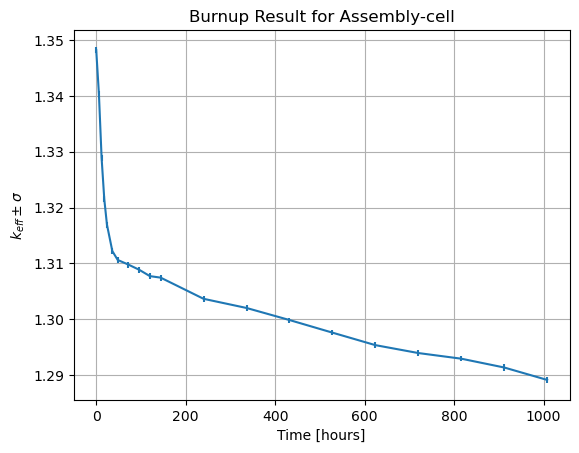

In [9]:
time, k = results.get_keff()
time /= (60*60)

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for Assembly-cell')
plt.xlabel('Time [hours]')
plt.ylabel('$k_{eff} \pm \sigma$')
plt.grid()

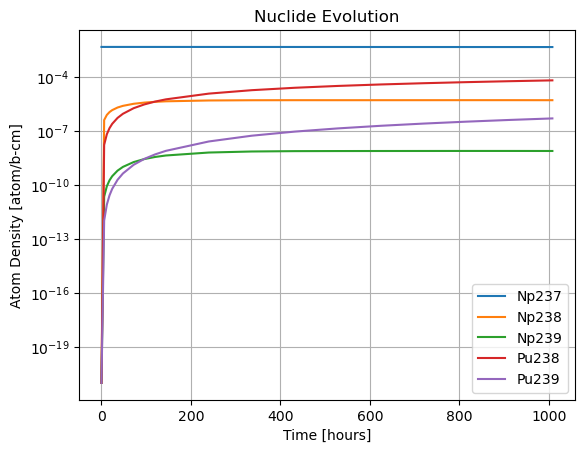

In [10]:
# check the materials.xml file to get the material number for the target
time, np237 = results.get_atoms("3","Np237",nuc_units="atom/b-cm",
                               time_units="h")
time, np238 = results.get_atoms("3","Np238",nuc_units="atom/b-cm",
                               time_units="h")
time, np239 = results.get_atoms("3","Np239",nuc_units="atom/b-cm",
                               time_units="h")
time, pu238 = results.get_atoms("3","Pu238",nuc_units="atom/b-cm",
                                time_units="h")
time, pu239 = results.get_atoms("3","Pu239",nuc_units="atom/b-cm",
                               time_units="h")

plt.semilogy(time,np237,label="Np237")
plt.semilogy(time,np238,label="Np238")
plt.semilogy(time,np239,label="Np239")
plt.semilogy(time,pu238,label="Pu238")
plt.semilogy(time,pu239,label="Pu239")
plt.title("Nuclide Evolution")
plt.xlabel("Time [hours]")
plt.ylabel("Atom Density [atom/b-cm]")
plt.grid()
plt.axis([0,])
plt.legend()